1.配置环境/导包
--

In [22]:
#配置和部署相关环境
import os
import torch
os.environ['KMP_DUPLICATE_LIB_OK']='True' #防止jupyter内核挂掉
torch.backends.cudnn.benchmark=True #用于加速GPU运算的代码

In [23]:
#导入pytorch一个完整流程所需的可能全部的包（能想到的都导入进来了）
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models as m
from torch.utils.data import DataLoader

In [24]:
#导入作为辅助工具的各类包
import matplotlib.pyplot as plt #可视化
from time import time #计算时间、记录时间
import datetime
import random #控制随机性
import numpy as np
import pandas as pd
import gc #garbage collector 垃圾回收

In [25]:
#设置全局的随机数种子
torch.manual_seed(1412) #torch
random.seed(1412) #random
np.random.seed(1412) #numpy.random

In [26]:
#使用GPU进行工作
torch.cuda.is_available()

True

In [27]:
#GPU系统会令device = "gpu", cpu系统会令device = "cpu"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

2.导入数据和数据增强的过程
--

In [32]:
#导入保存在D盘的SVHN数据集（训练集和测试集）
train = torchvision.datasets.SVHN(root ='D:\dataset\SVHN'
                                 ,split ="train"
                                 ,download = False
                                 ,transform = T.ToTensor()
                                 )

In [31]:
test = torchvision.datasets.SVHN(root ='D:\dataset\SVHN'
                                 ,split ="test"
                                 ,download = False
                                 ,transform = T.ToTensor())

In [37]:
train #看看数据集情况

Dataset SVHN
    Number of datapoints: 73257
    Root location: D:\dataset\SVHN
    Split: train
    StandardTransform
Transform: ToTensor()

In [38]:
test

Dataset SVHN
    Number of datapoints: 26032
    Root location: D:\dataset\SVHN
    Split: test
    StandardTransform
Transform: ToTensor()

In [40]:
# 可以很容易看出来这是一个十分类问题
np.unique(train.labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [47]:
#让每个数据集随机显示5张图像
def plotsample(data): #只能够接受tensor格式的图像
    fig, axs = plt.subplots(1,5,figsize=(10,10)) #建立子图
    for i in range(5):
        num = random.randint(0,len(data)-1) #首先选取随机数，随机选取五次
        #抽取数据中对应的图像对象，make_grid函数可将任意格式的图像的通道数升为3，而不改变图像原始的数据
        #而展示图像用的imshow函数最常见的输入格式也是3通道
        npimg = torchvision.utils.make_grid(data[num][0]).numpy()
        nplabel = data[num][1] #提取标签
        #将图像由(3, weight, height)转化为(weight, height, 3)，并放入imshow函数中读取
        axs[i].imshow(np.transpose(npimg, (1, 2, 0))) 
        axs[i].set_title(nplabel) #给每个子图加上标签
        axs[i].axis("off") #消除每个子图的坐标轴

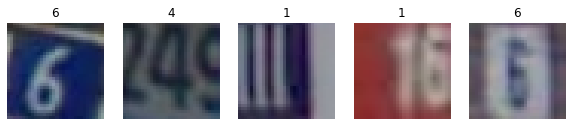

In [48]:
plotsample(train) #分辨率很低，数据集有一定的难度

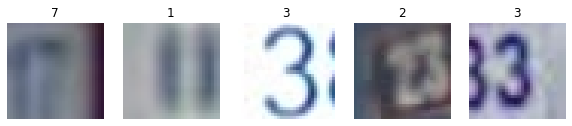

In [49]:
plotsample(test)

In [52]:
# 数据预处理和数据增强
trainT = T.Compose([T.RandomCrop(28)
                   ,T.RandomRotation(degrees = [-30,30])
                   ,T.ToTensor()
                   ,T.Normalize(mean = [0.485,0.456,0.406]
                                ,std = [0.229,0.224,0.225])])

In [53]:
testT = T.Compose([T.CenterCrop(28)
                  ,T.ToTensor()
                  ,T.Normalize(mean = [0.485,0.456,0.406]
                                ,std = [0.229,0.224,0.225])])

In [54]:
train = torchvision.datasets.SVHN(root ='D:\dataset\SVHN'
                                 ,split ="train"
                                 ,download = False
                                 ,transform = T.ToTensor()
                                 )

In [55]:
test = torchvision.datasets.SVHN(root ='D:\dataset\SVHN'
                                 ,split ="test"
                                 ,download = False
                                 ,transform = T.ToTensor())

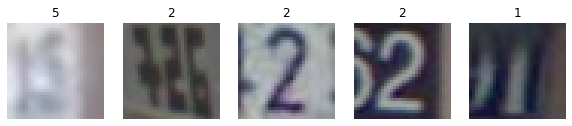

In [58]:
# 查看增强后的数据
plotsample(train)

3.基于经典架构构建自己的网络架构
--

In [61]:
#基于小型数据集，首先考虑使用各个经典架构中比较浅、但学习能力又比较强的架构
torch.manual_seed(1412)
resnet18_ = m.resnet18()
vgg16_ = m.vgg16()

In [62]:
#查看网络架构，从中选择我们希望使用的部分
resnet18_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [64]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = nn.Sequential(nn.Conv2d(3,64,kernel_size=3
                                              ,stride=1,padding=1,bias=False)
                                   ,resnet18_.bn1
                                   ,resnet18_.relu) #删除池化层
        
        #后续的架构直接从经典架构中选
        #对尺寸很小的数据集而言，我们的深度本来就不深，因此可以试着在特征图数量上有所增加（增加宽度）
        self.block2 = resnet18_.layer2 #2个残差单元
        self.block3 = resnet18_.layer3 #2个残差单元
        #自适应平均池化+线性层，此处都与残差网络一致
        self.avgpool = resnet18_.avgpool
        #确保输出的类别数量正确
        self.fc = nn.Linear(in_features=256, out_features=10, bias=True)
    
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],256)
        x = self.fc(x)
        return x

In [66]:
class MyVgg(nn.Module):
    def __init__(self):
        super().__init__()
        
        #在9层之后增加一个单独的卷积层，再加入池化层，构成(卷积x2+池化) + (卷积x3+池化)的类似AlexNet的结构
        self.features = nn.Sequential(*vgg16_.features[0:9] #星号用于解码
                                     ,nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
                                     ,nn.ReLU(inplace=True)
                                     ,nn.MaxPool2d(2,2, padding=0, dilation=1, ceil_mode=False))
        #进入线性层时输入通道数发生变化，因此线性层需要重写
        #输出层也需要重写
        self.avgpool = vgg16_.avgpool
        self.fc = nn.Sequential(nn.Linear(7*7*128, out_features=4096,bias=True)
                                ,*vgg16_.classifier[1:6]
                                ,nn.Linear(in_features=4096, out_features=10,bias=True))
    
    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],7*7*128)
        x = self.fc(x)
        return x

In [68]:
from torchinfo import summary

In [69]:
summary(MyResNet(),(10,3,28,28),depth=2,device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
MyResNet                                 [10, 10]                  --
├─Sequential: 1-1                        [10, 64, 28, 28]          --
│    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,728
│    └─BatchNorm2d: 2-2                  [10, 64, 28, 28]          128
│    └─ReLU: 2-3                         [10, 64, 28, 28]          --
├─Sequential: 1-2                        [10, 128, 14, 14]         --
│    └─BasicBlock: 2-4                   [10, 128, 14, 14]         230,144
│    └─BasicBlock: 2-5                   [10, 128, 14, 14]         295,424
├─Sequential: 1-3                        [10, 256, 7, 7]           --
│    └─BasicBlock: 2-6                   [10, 256, 7, 7]           919,040
│    └─BasicBlock: 2-7                   [10, 256, 7, 7]           1,180,672
├─AdaptiveAvgPool2d: 1-4                 [10, 256, 1, 1]           --
├─Linear: 1-5                            [10, 10]          

In [71]:
summary(MyVgg(),(10,3,28,28),depth=2,device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
MyVgg                                    [10, 10]                  --
├─Sequential: 1-1                        [10, 128, 7, 7]           --
│    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,792
│    └─ReLU: 2-2                         [10, 64, 28, 28]          --
│    └─Conv2d: 2-3                       [10, 64, 28, 28]          36,928
│    └─ReLU: 2-4                         [10, 64, 28, 28]          --
│    └─MaxPool2d: 2-5                    [10, 64, 14, 14]          --
│    └─Conv2d: 2-6                       [10, 128, 14, 14]         73,856
│    └─ReLU: 2-7                         [10, 128, 14, 14]         --
│    └─Conv2d: 2-8                       [10, 128, 14, 14]         147,584
│    └─ReLU: 2-9                         [10, 128, 14, 14]         --
│    └─Conv2d: 2-10                      [10, 128, 14, 14]         147,584
│    └─ReLU: 2-11                        [10, 128, 14, 14]      

In [72]:
[*MyResNet().block2[0].parameters()][0][0][0]

tensor([[ 0.0324, -0.0175,  0.0459],
        [ 0.0728, -0.0392,  0.0903],
        [-0.0266, -0.0177, -0.0227]], grad_fn=<SelectBackward0>)

In [73]:
[*resnet18_.layer2[0].conv1.parameters()][0][0][0]

tensor([[ 0.0324, -0.0175,  0.0459],
        [ 0.0728, -0.0392,  0.0903],
        [-0.0266, -0.0177, -0.0227]], grad_fn=<SelectBackward0>)

In [75]:
[*resnet18_.fc.parameters()]
[*MyResNet().fc.parameters()]

[Parameter containing:
 tensor([[-0.0429, -0.0230, -0.0052,  ...,  0.0229,  0.0624,  0.0123],
         [ 0.0374,  0.0305, -0.0507,  ..., -0.0078,  0.0021,  0.0418],
         [-0.0071, -0.0486, -0.0362,  ..., -0.0543,  0.0083, -0.0440],
         ...,
         [-0.0503,  0.0252, -0.0286,  ...,  0.0542, -0.0136,  0.0468],
         [ 0.0578,  0.0262, -0.0110,  ..., -0.0442, -0.0436,  0.0028],
         [ 0.0244,  0.0292,  0.0102,  ...,  0.0236,  0.0615, -0.0255]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0501, -0.0285, -0.0333,  0.0280,  0.0232, -0.0408,  0.0043,  0.0058,
          0.0399,  0.0305], requires_grad=True)]

4.提前停止
--

In [77]:
class EarlyStopping():
    def __init__(self, patience = 5, tol = 0.0005): #惯例地定义我们所需要的一切变量/属性\
        #当连续patience次迭代时，这一轮迭代的损失与历史最低损失之间的差值小于阈值时
        #就触发提前停止
        
        self.patience = patience
        self.tol = tol #tolerance，累积5次都低于tol才会触发停止
        self.counter = 0 #计数，计算现在已经累积了counter次
        self.lowest_loss = None
        self.early_stop = False #True - 提前停止，False - 不要提前停止
    
    def __call__(self,val_loss):
        if self.lowest_loss == None: #这是第一轮迭代
            self.lowest_loss = val_loss
        elif self.lowest_loss - val_loss > self.tol:
            self.lowest_loss = val_loss
            self.counter = 0
        elif self.lowest_loss - val_loss < self.tol:
            self.counter += 1
            print("\t NOTICE: Early stopping counter {} of {}".format(self.counter,self.patience))
            if self.counter >= self.patience:
                print('\t NOTICE: Early Stopping Actived')
                self.early_stop = True
        return self.early_stop
        #这一轮迭代的损失与历史最低损失之间的差 - 阈值

5.训练函数
--

In [78]:
sigma = torch.ones([3,3]) + np.random.normal(size=(3,3))

In [79]:
sigma #zhat/sigma值最高的那一列所对应的类别就是这个样本的预测类别

tensor([[ 1.3365,  1.5069,  0.9017],
        [ 0.2944,  2.1113,  0.2333],
        [ 2.0792, -1.1104,  0.3480]], dtype=torch.float64)

In [81]:
yhat = torch.max(sigma,1)[1]
y = torch.tensor([1,1,2])
(yhat == y).sum()/3

tensor(0.6667)

In [82]:
a = ["apple","banana","orange"]

In [83]:
def IterOnce(net,criterion,opt,x,y):
    """
    对模型进行一次迭代的函数
    
    net: 实例化后的架构
    criterion: 损失函数
    opt: 优化算法
    x: 这一个batch中所有的样本
    y: 这一个batch中所有样本的真实标签
    """
    sigma = net.forward(x)
    loss = criterion(sigma,y)
    loss.backward()
    opt.step()
    opt.zero_grad(set_to_none=True) #比起设置梯度为0，让梯度为None会更节约内存
    yhat = torch.max(sigma,1)[1]
    correct = torch.sum(yhat == y)
    return correct,loss

In [84]:
def TestOnce(net,criterion,x,y):
    """
    对一组数据进行测试并输出测试结果的函数
    
    net: 经过训练后的架构
    criterion：损失函数
    x：要测试的数据的所有样本
    y：要测试的数据的真实标签
    """
    #对测试，一定要阻止计算图追踪
    #这样可以节省很多内存，加速运算
    with torch.no_grad(): 
        sigma = net.forward(x)
        loss = criterion(sigma,y)
        yhat = torch.max(sigma,1)[1]
        correct = torch.sum(yhat == y)
    return correct,loss

In [97]:
def fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH):
    """
    对模型进行训练，并在每个epoch后输出训练集和测试集上的准确率/损失
    以实现对模型的监控
    实现模型的保存
    
    参数说明：
    net: 实例化后的网络
    batchdata：使用Dataloader分割后的训练数据
    testdata：使用Dataloader分割后的测试数据
    criterion：所使用的损失函数
    opt：所使用的优化算法
    epochs：一共要使用完整数据集epochs次
    tol：提前停止时测试集上loss下降的阈值，连续5次loss下降不超过tol就会触发提前停止
    modelname：现在正在运行的模型名称，用于保存权重时作为文件名
    PATH：将权重文件保存在path目录下
    
    """
    
    SamplePerEpoch = batchdata.dataset.__len__() #整个epoch里有多少个样本
    allsamples = SamplePerEpoch*epochs
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    early_stopping = EarlyStopping(tol=tol)
    highestacc = None
    
    for epoch in range(1,epochs+1):
        net.train()
        correct_train = 0
        loss_train = 0
        for batch_idx, (x, y) in enumerate(batchdata):
            #non_blocking 非阻塞 = True
            x = x.to(device,non_blocking=True)
            y = y.to(device,non_blocking=True).view(x.shape[0])
            correct, loss = IterOnce(net,criterion,opt,x,y)
            
            #计算样本总量、总的correct、loss
            trainedsamples += x.shape[0]
            loss_train += loss
            correct_train += correct
            
            if (batch_idx+1) % 125 == 0:
                #现在进行到了哪个epoch
                #现在训练到了多少个样本
                #总共要训练多少个样本
                #现在的训练的样本占总共需要训练的样本的百分比
                print('Epoch{}:[{}/{}({:.0f}%)]'.format(epoch
                                                       ,trainedsamples
                                                       ,allsamples
                                                       ,100*trainedsamples/allsamples))
            
        TrainAccThisEpoch = float(correct_train*100)/SamplePerEpoch
        TrainLossThisEpoch = float(loss_train*100)/SamplePerEpoch #平均每个样本上的损失
        trainlosslist.append(TrainLossThisEpoch)
        
        #清理GPU内存
        #清理掉一个epoch循环下面不再需要的中间变量
        del x,y,correct,loss,correct_train,loss_train #删除数据与变量
        gc.collect() #清除数据与变量相关的缓存
        torch.cuda.empty_cache() #缓存分配器分配出去的内存给释放掉
    
        #每次训练完一个epoch，就在测试集上验证一下模型现在的效果
        net.eval()
        loss_test = 0
        correct_test = 0
        loss_test = 0
        TestSample = testdata.dataset.__len__()

        for x,y in testdata:
            x = x.to(device, non_blocking=True)
            y = y.to(device,non_blocking=True).view(x.shape[0])
            correct, loss = TestOnce(net,criterion,x,y)
            loss_test += loss
            correct_test += correct

        TestAccThisEpoch = float(correct_test * 100)/TestSample
        TestLossThisEpoch = float(loss_test * 100)/TestSample
        testlosslist.append(TestLossThisEpoch)
        
        #清理GPU内存
        del x,y,correct,loss,correct_test,loss_test
        gc.collect()
        torch.cuda.empty_cache()
        
        #对每一个epoch，打印训练和测试的结果
        #训练集上的损失，测试集上的损失，训练集上的准确率，测试集上的准确率
        print("\t Train Loss:{:.6f}, Test Loss:{:.6f}, Train Acc:{:.3f}%, Test Acc:{:.3f}%".format(TrainLossThisEpoch
                                                                                                  ,TestLossThisEpoch
                                                                                                  ,TrainAccThisEpoch
                                                                                                  ,TestAccThisEpoch))
        
        #如果测试集准确率出现新高/测试集loss出现新低，那我会保存现在的这一组权重
        if highestacc == None: #首次进行测试
            highestacc = TestAccThisEpoch
        if highestacc < TestAccThisEpoch:
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(),os.path.join(PATH,modelname+".pt"))
            print("\t Weight Saved")
        
        #提前停止
        early_stop = early_stopping(TestLossThisEpoch)
        if early_stop == "True":
            break
            
    print("Complete")
    return trainlosslist, testlosslist

In [98]:
# 一些参数 
bs = 128   # batchsize
lr = 0.001  #  learning rate
alpha = 0.99
gamma = 0
wd = 0 # weight_decay

In [99]:
batchdata = DataLoader(train,batch_size=bs,shuffle=True
                       ,drop_last=False,num_workers = 4)
testdata = DataLoader(test,batch_size=bs,shuffle=False
                      ,drop_last=False,num_workers = 4)

In [102]:
def full_procedure(net,epochs,bs,modelname, PATH, lr=0.001,alpha=0.99,gamma=0,wd=0,tol=10**(-5)):
    
    torch.cuda.manual_seed(1412)
    torch.cuda.manual_seed_all(1412)
    torch.manual_seed(1412)
    
    #分割数据
    batchdata = DataLoader(train,batch_size=bs,shuffle=True
                       ,drop_last=False,pin_memory=True)
    testdata = DataLoader(test,batch_size=bs,shuffle=False
                      ,drop_last=False,pin_memory=True)
    
    #损失函数，优化算法
    criterion = nn.CrossEntropyLoss(reduction="sum") #进行损失函数计算时，最后输出结果的计算模式
    opt = optim.RMSprop(net.parameters(),lr=lr
                        ,alpha=alpha,momentum=gamma,weight_decay=wd)
    
    #训练与测试
    trainloss, testloss = fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH)
    
    return trainloss, testloss

In [101]:
#绘图函数
def plotloss(trainloss, testloss):
    plt.figure(figsize=(10, 7))
    plt.plot(trainloss, color="red", label="Trainloss")
    plt.plot(testloss, color="orange", label="Testloss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

6.模型选择
--

In [110]:
# 我们构建了两个架构，MyResNet和MyVgg

In [111]:
from torchinfo import summary
for name,i in[("ResNet",MyResNet()),("VGG",MyVgg())]:
    print("\n")
    print(name)
    print(summary(i,input_size=(10,3,28,28),depth=2,device="cpu"))
    print("\n")



ResNet
Layer (type:depth-idx)                   Output Shape              Param #
MyResNet                                 [10, 10]                  --
├─Sequential: 1-1                        [10, 64, 28, 28]          --
│    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,728
│    └─BatchNorm2d: 2-2                  [10, 64, 28, 28]          128
│    └─ReLU: 2-3                         [10, 64, 28, 28]          --
├─Sequential: 1-2                        [10, 128, 14, 14]         --
│    └─BasicBlock: 2-4                   [10, 128, 14, 14]         230,144
│    └─BasicBlock: 2-5                   [10, 128, 14, 14]         295,424
├─Sequential: 1-3                        [10, 256, 7, 7]           --
│    └─BasicBlock: 2-6                   [10, 256, 7, 7]           919,040
│    └─BasicBlock: 2-7                   [10, 256, 7, 7]           1,180,672
├─AdaptiveAvgPool2d: 1-4                 [10, 256, 1, 1]           --
├─Linear: 1-5                            [10, 10] 

In [112]:
#在每一个架构上，分别运行3个epochs，运行5次

In [113]:
#建立目录用于存储模型选择结果
PATH = r"D:\deeplearning\modelselect"

#使用函数full_procedure中的默认参数，在模型选择时加入时间计算
#基于现有显存，batch_size被设置为256


#MyResNet
avgtime = [] #用来存放每次循环之后获得的训练时间
for i in range(5): #进行5次训练
    #设置随机数种子
    torch.manual_seed(1412)
    
    #实例化
    resnet18_ = m.resnet18()
    net = MyResNet().to(device,non_blocking=True)
    
    #训练
    start = time() #计算训练时间
    trainloss, testloss = full_procedure(net,epochs=3, bs=256 
                                         ,modelname="model_seletion_resnet"
                                         ,PATH = PATH)
    avgtime.append(time()-start)

Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:110.085760, Test Loss:33.313878, Train Acc:62.967%, Test Acc:90.608%
Epoch2:[105257/219771(48%)]
Epoch2:[137257/219771(62%)]
	 Train Loss:27.755315, Test Loss:31.033778, Train Acc:91.750%, Test Acc:90.857%
	 Weight Saved
Epoch3:[178514/219771(81%)]
Epoch3:[210514/219771(96%)]
	 Train Loss:21.908983, Test Loss:27.437990, Train Acc:93.627%, Test Acc:91.699%
	 Weight Saved
Complete
Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:106.803295, Test Loss:35.704361, Train Acc:64.260%, Test Acc:89.267%
Epoch2:[105257/219771(48%)]
Epoch2:[137257/219771(62%)]
	 Train Loss:28.006815, Test Loss:33.722543, Train Acc:91.602%, Test Acc:89.839%
	 Weight Saved
Epoch3:[178514/219771(81%)]
Epoch3:[210514/219771(96%)]
	 Train Loss:22.200814, Test Loss:27.873355, Train Acc:93.550%, Test Acc:91.902%
	 Weight Saved
Complete
Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:107.919271, Test Loss:34.263294, Tr

In [114]:
#打印出我们的平均时间
print(np.mean(avgtime))

336.70050940513613


In [121]:
#MyVGG
avgtime = []
for i in range(5):
    torch.manual_seed(1412)
    vgg16_ = m.vgg16_bn()
    net = MyVgg().to(device,non_blocking=True)
    start = time() #计算训练时间
    #此时使用的是full_procedure的默认参数
    trainloss, testloss = full_procedure(net,epochs=3, bs=256
                                         ,modelname="model_seletion_vgg"
                                         ,PATH = PATH)
    avgtime.append(time()-start)

Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:3020.976780, Test Loss:215.712104, Train Acc:18.185%, Test Acc:23.886%
Epoch2:[105257/219771(48%)]
Epoch2:[137257/219771(62%)]
	 Train Loss:185.778069, Test Loss:117.773029, Train Acc:35.594%, Test Acc:63.199%
	 Weight Saved
Epoch3:[178514/219771(81%)]
Epoch3:[210514/219771(96%)]
	 Train Loss:105.479224, Test Loss:73.128529, Train Acc:66.063%, Test Acc:78.546%
	 Weight Saved
Complete
Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:3021.373411, Test Loss:213.559120, Train Acc:18.101%, Test Acc:27.197%
Epoch2:[105257/219771(48%)]
Epoch2:[137257/219771(62%)]
	 Train Loss:181.818011, Test Loss:112.185080, Train Acc:36.932%, Test Acc:66.276%
	 Weight Saved
Epoch3:[178514/219771(81%)]
Epoch3:[210514/219771(96%)]
	 Train Loss:107.116856, Test Loss:76.603901, Train Acc:65.994%, Test Acc:77.282%
	 Weight Saved
Complete
Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:3020.431413, Test Loss:21

In [123]:
#打印出我们的平均时间
print(np.mean(avgtime))

247.86623287200928


In [ ]:
# 用来进行垃圾回收的
del net
gc.collect()
torch.cuda.empty_cache()

7.模型调优/参数调整
--

myResNet_test0
Epoch1:[32000/732570(4%)]
Epoch1:[64000/732570(9%)]
	 Train Loss:107.468686, Test Loss:33.113598, Train Acc:63.846%, Test Acc:90.523%
Epoch2:[105257/732570(14%)]
Epoch2:[137257/732570(19%)]
	 Train Loss:27.886574, Test Loss:34.442679, Train Acc:91.639%, Test Acc:89.640%
	 NOTICE: Early stopping counter 1 of 5
Epoch3:[178514/732570(24%)]
Epoch3:[210514/732570(29%)]
	 Train Loss:22.022663, Test Loss:28.326829, Train Acc:93.573%, Test Acc:91.530%
	 Weight Saved
Epoch4:[251771/732570(34%)]
Epoch4:[283771/732570(39%)]
	 Train Loss:18.375715, Test Loss:22.212709, Train Acc:94.709%, Test Acc:93.662%
	 Weight Saved
Epoch5:[325028/732570(44%)]
Epoch5:[357028/732570(49%)]
	 Train Loss:15.966041, Test Loss:22.671575, Train Acc:95.471%, Test Acc:93.654%
	 NOTICE: Early stopping counter 1 of 5
Epoch6:[398285/732570(54%)]
Epoch6:[430285/732570(59%)]
	 Train Loss:13.533690, Test Loss:24.814526, Train Acc:96.258%, Test Acc:92.578%
	 NOTICE: Early stopping counter 2 of 5
Epoch7:[471542/7

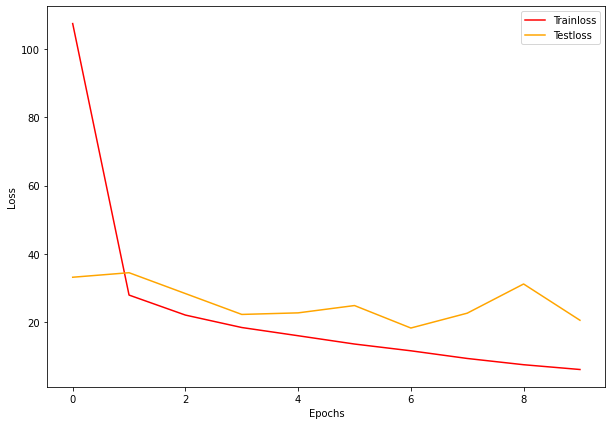

In [124]:
#尝试增加到10个epochs
PATH = r"D:\deeplearning\modelselect"
modelname = "myResNet_test0"

print(modelname)
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = MyResNet().to(device,non_blocking=True)
start = time() #计算训练时间
trainloss, testloss = full_procedure(net,epochs=10, bs=256
                                     ,modelname=modelname
                                     ,PATH = PATH)
print(time()-start)
plotloss(trainloss,testloss)